In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf
from arch import arch_model 

plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

In [ ]:
# !conda install yfinance
 !pip install arch

###  Скачиваем котировки компаний Apple, HSBC и Toyota

In [2]:
data = yf.download("AAPL HSBC TM", start="2015-01-01", end="2019-01-01", group_by="ticker")

data.head()

[*********************100%***********************]  3 of 3 completed


AAPL                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2014-12-31  112.820000  113.129997  110.209999  110.379997  101.419060   
2015-01-02  111.389999  111.440002  107.349998  109.330002  100.454300   
2015-01-05  108.290001  108.650002  105.410004  106.250000   97.624336   
2015-01-06  106.540001  107.430000  104.629997  106.260002   97.633545   
2015-01-07  107.199997  108.199997  106.699997  107.750000   99.002556   

                           HSBC                                              \
              Volume       Open       High        Low      Close  Adj Close   
Date                                                                          
2014-12-31  41403400  47.490002  47.549999  47.180000  47.230000  34.711212   
2015-01-02  53204600  47.299999  47.330002  46.849998  47.070000  34.593620   
2015-01-05  64285500  46.259998  46.340000  45.799999  45.990002  33.799889   
2015-01-06  65797100  45.439999  45.680000  45.009998  45.320000  33.307472   
2015-01-07  40105900  45.459999  45.720001  45.230000  45.669998  33.564701   

                             TM                                      \
             Volume        Open        High         Low       Close   
Date                                                                  
2014-12-31  1178400  125.599998  126.209999  125.400002  125.480003   
2015-01-02  1446500  126.230003  126.639999  124.889999  125.669998   
2015-01-05  2599600  124.440002  124.610001  123.050003  123.370003   
2015-01-06  3408100  123.400002  123.720001  121.209999  122.099998   
2015-01-07  2122400  125.519997  126.059998  125.059998  125.169998   

                                
             Adj Close  Volume  
Date                            
2014-12-31  107.120560  151100  
2015-01-02  107.282745  250000  
2015-01-05  105.319267  240600  
2015-01-06  104.235085  285600  
2015-01-07  106.855896  385700

In [3]:
prices = []

for ticker in data.columns.levels[0]:

    temp = data[ticker]['Close']
    temp.name = ticker
    prices.append(temp)

    
prices = pd.concat(prices, axis=1)

prices.head()

,AAPL,HSBC,TM
Date,,,
2014-12-31,110.379997,47.230000,125.480003
2015-01-02,109.330002,47.070000,125.669998
2015-01-05,106.250000,45.990002,123.370003
2015-01-06,106.260002,45.320000,122.099998
2015-01-07,107.750000,45.669998,125.169998


###  Строим график цен и смотрим на него

Text(0.5,1,'Stock price')

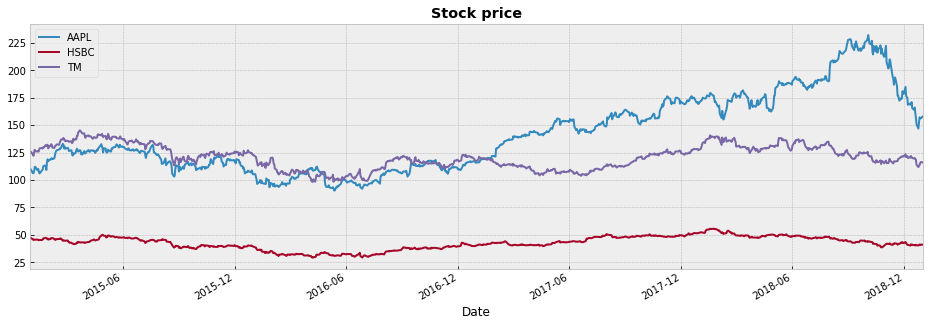

In [4]:
prices.plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

###  Теперь посмотрим на графики доходностей

In [5]:
returns = 100*prices.pct_change().dropna()

returns.head()

,AAPL,HSBC,TM
Date,,,
2015-01-02,-0.951255,-0.338767,0.151414
2015-01-05,-2.817161,-2.294451,-1.830187
2015-01-06,0.009414,-1.456843,-1.029427
2015-01-07,1.402219,0.772283,2.514332
2015-01-08,3.842227,0.328447,1.925384


Text(0.5,1,'Daily returns')

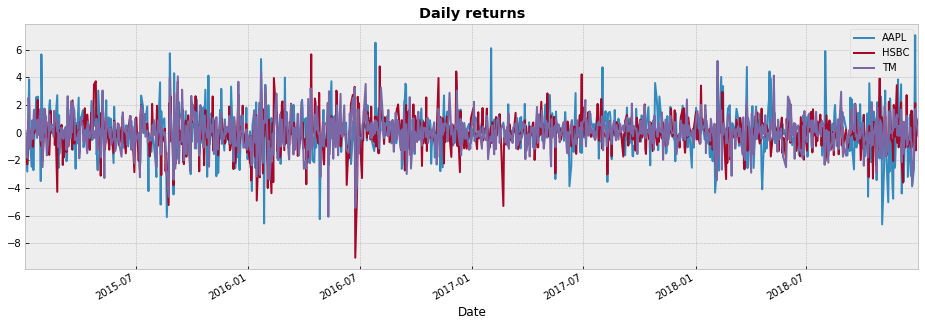

In [6]:
returns.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")

Text(0.5,1,'Daily returns')

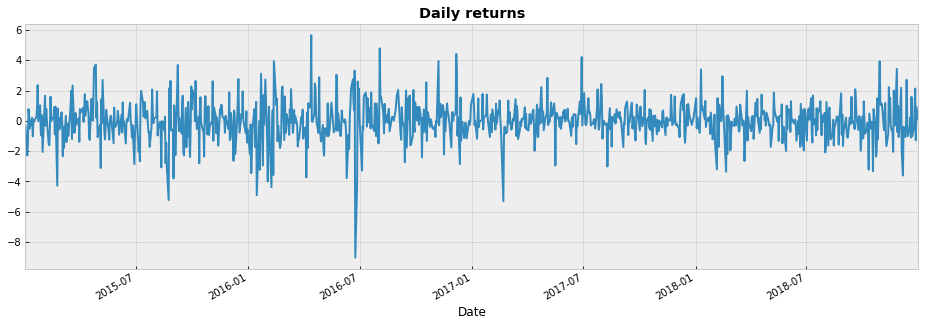

In [7]:
ret = returns['HSBC']

ret.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")

### А теперь посмотрим на гистограмму распределения доходностей

### Его-то мы и будем сегодня моделировать, чтобы посчитать Value-at-Risk и Expected Shortfall (VaR и ES)

Text(0.5,1,'Histogram of daily returns')

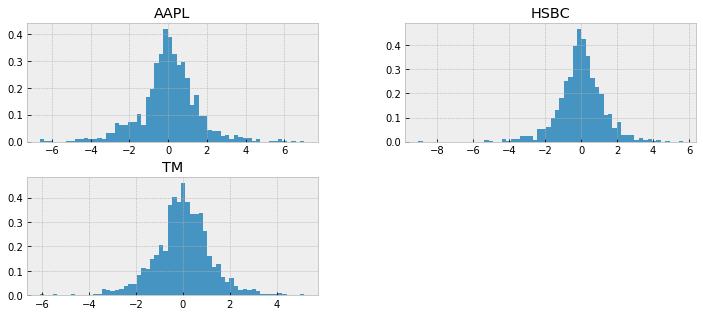

In [8]:
returns.hist(bins=60, density=True, histtype="stepfilled", alpha=0.9, figsize=(12, 5))
plt.title("Histogram of daily returns", weight="bold")

Text(0.5,1,'Histogram of daily returns')

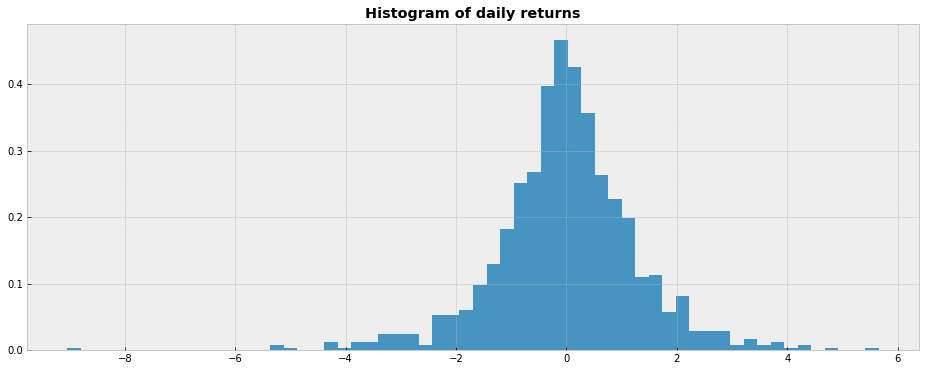

In [9]:
ret.hist(bins=60, density=True, histtype="stepfilled", alpha=0.9, figsize=(16, 6))
plt.title("Histogram of daily returns", weight="bold")

### Сначала посчитаем метрики самым простым способом -- Historical Simulation

Делать все будем для уровня потерь в 10%, посмотрим на каждую акцию по-отдельности

In [10]:
alpha = 0.10

In [11]:
ret = returns['AAPL']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

Value-at-Risk: -1.76%
Expected Shortfall: -2.87%


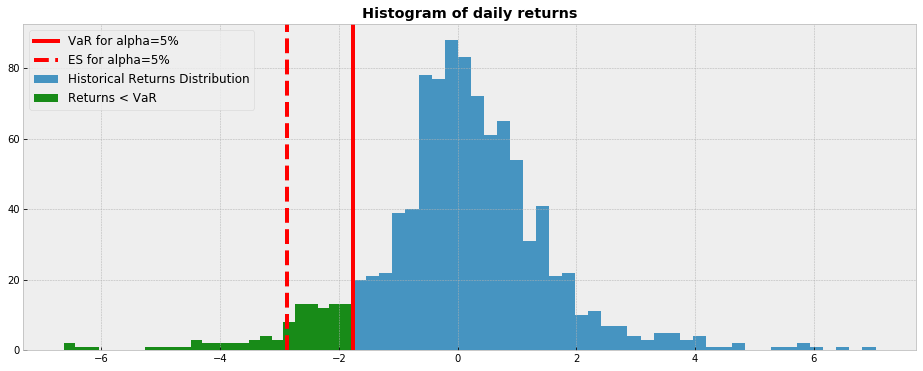

In [12]:
VaR_HS = ret.quantile(alpha)
ES_HS = ret[ret < VaR_HS].mean()

ret[ret >= VaR_HS].hist(bins=40, histtype="stepfilled", alpha=0.9, figsize=(16, 6))
plt.hist(ret[ret < VaR_HS], alpha=0.9, bins=25, color='g')
plt.title("Histogram of daily returns", weight="bold")

plt.axvline(x=VaR_HS, linewidth=4, color="r")
plt.axvline(ES_HS, linewidth=4, color='red', linestyle='dashed')

plt.legend(['VaR for alpha=5%',
            'ES for alpha=5%',
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

print('Value-at-Risk: {:.2f}%'.format(VaR_HS))
print('Expected Shortfall: {:.2f}%'.format(ES_HS))

### Теперь будем использовать разные модельные распределения для аппроксимации

### И начнем с нормального распределения

In [24]:
ret = returns['AAPL']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

Value-at-Risk: -1.93%
Expected Shortfall: -2.66%


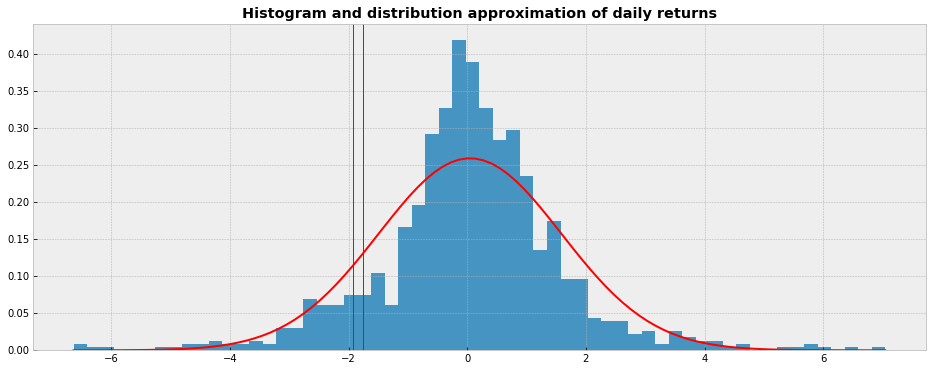

In [25]:
norm_mean, norm_sigma = scipy.stats.norm.fit(ret)

VaR_norm = scipy.stats.norm.ppf(alpha, norm_mean, norm_sigma)
ES_norm = scipy.stats.norm.expect(loc=norm_mean, scale=norm_sigma, ub=VaR_norm, conditional=True)

support = np.linspace(ret.min(), ret.max(), 100)

ret.hist(bins=60, density=True, histtype="stepfilled", alpha=0.9, figsize=(16, 6))
plt.axvline(x=VaR_norm, linewidth=1, color="r")
plt.axvline(x=VaR_HS, linewidth=1, color="g")

plt.plot(support, scipy.stats.norm.pdf(support, loc=norm_mean, scale=norm_sigma), "r-")
plt.title("Histogram and distribution approximation of daily returns", weight="bold")

print('Value-at-Risk: {:.2f}%'.format(VaR_norm))
print('Expected Shortfall: {:.2f}%'.format(ES_norm))

### Мы посмотрели на гистограмму, а также можем посмотреть на график квантиль-квантиль

Text(0.5,1,'Normal QQ-plot of daily returns')

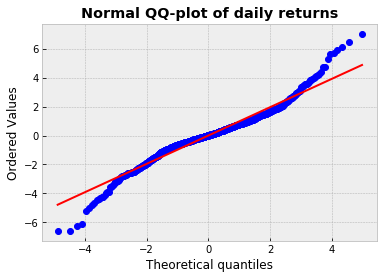

In [26]:
scipy.stats.probplot(ret, dist=scipy.stats.norm, sparams=(norm_mean, norm_sigma), plot=plt.figure().add_subplot(111))
plt.title("Normal QQ-plot of daily returns", weight="bold")

### Теперь попробуем распределение Стьюдента

In [27]:
ret = returns['HSBC']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

Estimated parameters: 3.4818989384736465 0.012616265164582578 0.8955178979625749
Value-at-Risk: -1.40%
Expected Shortfall: -2.38%


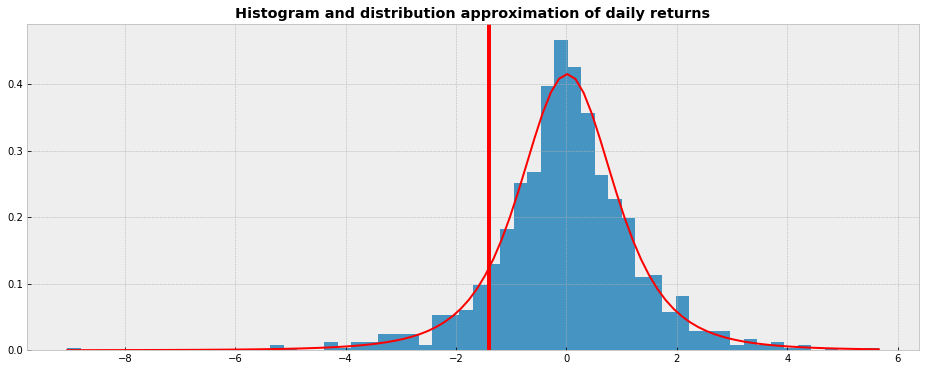

In [28]:
t_df, t_mean, t_sigma = scipy.stats.t.fit(ret)

VaR_t = scipy.stats.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = scipy.stats.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

support = np.linspace(ret.min(), ret.max(), 100)

ret.hist(bins=60, density=True, histtype="stepfilled", alpha=0.9, figsize=(16, 6))

plt.plot(support, scipy.stats.t.pdf(support, loc=t_mean, scale=t_sigma, df=t_df), "r-")
plt.axvline(x=VaR_t, linewidth=4, color="r")

plt.title("Histogram and distribution approximation of daily returns", weight="bold")

print('Estimated parameters:', t_df, t_mean, t_sigma)
print('Value-at-Risk: {:.2f}%'.format(VaR_t))
print('Expected Shortfall: {:.2f}%'.format(ES_t))

Text(0.5, 1.0, 'Student QQ-plot of daily returns')

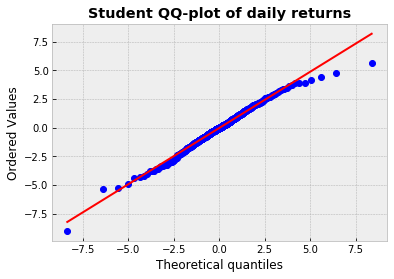

In [72]:
scipy.stats.probplot(ret, dist=scipy.stats.t, sparams=(t_df, t_mean, t_sigma), plot=plt.figure().add_subplot(111))
plt.title("Student QQ-plot of daily returns", weight="bold")

### И наконец, попробуем использовать обобщенное нормальное распределение

In [73]:
ret = returns['AAPL']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

Estimated parameters: 1.0202209646046072 0.049226753928936426 1.1191460152365806
Value-at-Risk: -1.70%
Expected Shortfall: -2.77%


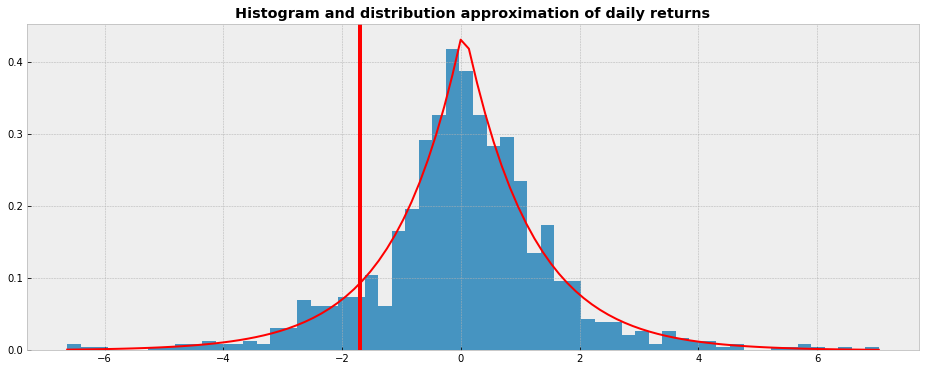

In [74]:
beta, loc, scale = scipy.stats.gennorm.fit(ret)

VaR_gennorm = scipy.stats.gennorm.ppf(alpha, beta, loc, scale)
ES_gennorm = scipy.stats.gennorm.expect(args=(beta,), loc=loc, scale=scale, ub=VaR_gennorm, conditional=True)

support = np.linspace(ret.min(), ret.max(), 100)

ret.hist(bins=60, density=True, histtype="stepfilled", alpha=0.9, figsize=(16, 6))
plt.axvline(x=VaR_gennorm, linewidth=4, color="r")

plt.plot(support, scipy.stats.gennorm.pdf(support, beta, loc, scale), "r-")
plt.title("Histogram and distribution approximation of daily returns", weight="bold")

print('Estimated parameters:', beta, loc, scale)
print('Value-at-Risk: {:.2f}%'.format(VaR_gennorm))
print('Expected Shortfall: {:.2f}%'.format(ES_gennorm))

Text(0.5, 1.0, 'Student QQ-plot of daily returns')

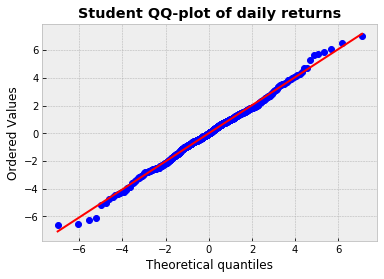

In [75]:
scipy.stats.probplot(ret, dist=scipy.stats.gennorm, sparams=(beta, loc, scale), plot=plt.figure().add_subplot(111))
plt.title("Student QQ-plot of daily returns", weight="bold")

### На досуге можно попробовать другие распределения, которые есть в библиотеке scipy.stats, а можно написать и свое собственное (не все распределения там реализованы)

Список распределений тут -- https://docs.scipy.org/doc/scipy/reference/stats.html

### Вроде бы все получается хорошо, но левый "хвост" распределения моделировать все равно сложно

### Так давайте использовать Теорию экстремальных значений!

### Здесь мы начнем с распределения максим и Generalized Extreme Value distribution

In [29]:
ret = returns['HSBC']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

In [30]:
n = 50

m = int(len(ret)/n)
print(n, 'блоков по', m, 'наблюдений')
maximas = []

for j in range(n):
    new_maximum = (-ret[j*m+1:(j+1)*m]).max()
    
    maximas.append(new_maximum)
    
maximas = np.array(maximas)

50 блоков по 20 наблюдений


### Это гистограмма распределения минимальных значений в каждом блоке по 20 наблюдений -- то есть это минимальные значения доходностей в каждые 4 рабочие недели

Text(0.5, 1.0, 'Histogram of maximas (left tail)')

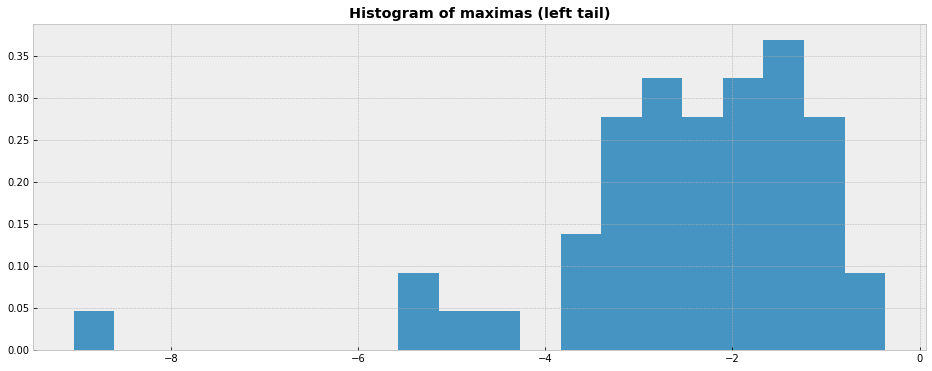

In [85]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(-maximas, bins=20, density=True, histtype="stepfilled", alpha=0.9)
plt.title("Histogram of maximas (left tail)", weight="bold")

### Как видите, наблюдений тут мало, поэтому GEV распределение как будто не очень "попадает" в данные

1.0202209646046072 1.831832787995446 0.9625614212708031


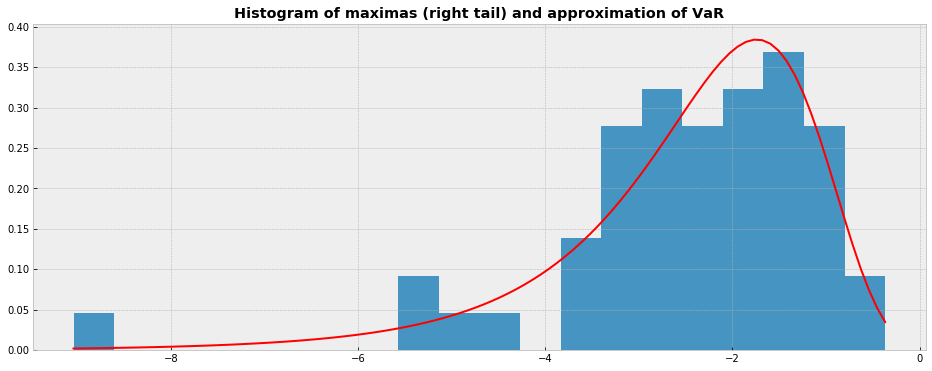

In [86]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html

b, loc, scale = scipy.stats.genextreme.fit(maximas)

support = np.linspace(maximas.min(), maximas.max(), 100)

fig = plt.figure()
fig.set_size_inches(16,6)
plt.hist(-maximas, bins=20, density=True, histtype="stepfilled", alpha=0.9)

plt.plot(-support, scipy.stats.genextreme.pdf(support, b, loc, scale), "r-")
plt.title("Histogram of maximas (right tail) and approximation of VaR", weight="bold")

print(beta, loc, scale)

### Однако график квантиль-квантиль выглядит хорошо, лишь самые экстремальные значения моделируются не идеально

Text(0.5, 1.0, 'Student QQ-plot of maximal returns')

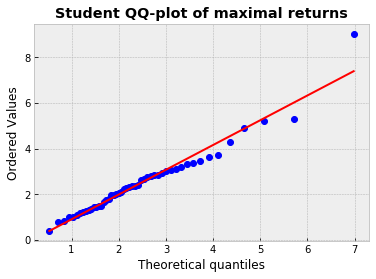

In [87]:
scipy.stats.probplot(maximas, dist=scipy.stats.genextreme, sparams=(b, loc, scale), plot=plt.figure().add_subplot(111))
plt.title("Student QQ-plot of maximal returns", weight="bold")

### Мы смоделировали распределение минимальных значений доходностей, осталось только правильно посчитать VaR для исходного распределения доходностей -- это остается на ДЗ, смотрите лекции ЕН

### Теперь будем моделировать сам левый хвост распределения доходностей с помощью Generalized Pareto распределения

In [99]:
ret = returns['TM']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

In [100]:
u = ret.quantile(alpha*2)

print(u)

ret_tail = ret[ret <= u]

-0.8424878169653871


Text(0.5, 1.0, 'Histogram of left tail')

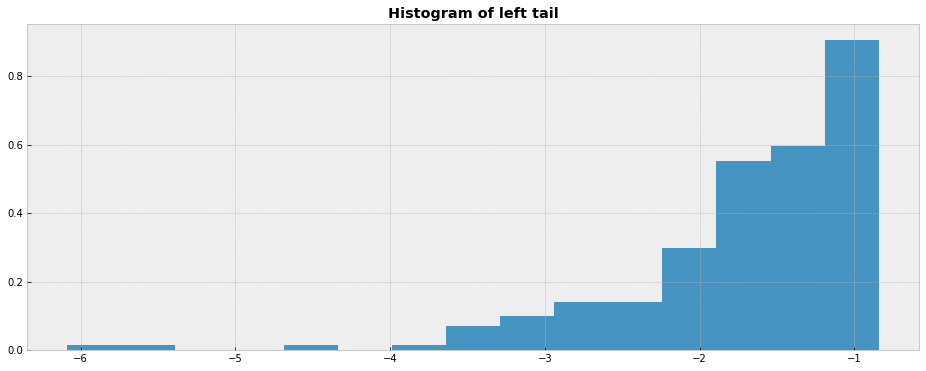

In [101]:
fig = plt.figure()
fig.set_size_inches(16,6)

plt.hist(ret_tail, bins=15, density=True, histtype="stepfilled", alpha=0.9)
plt.title("Histogram of left tail", weight="bold")

C:\Users\stepa\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2247: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
C:\Users\stepa\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
C:\Users\stepa\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


1.0202209646046072 0.008424878164203235 0.008719725029175639


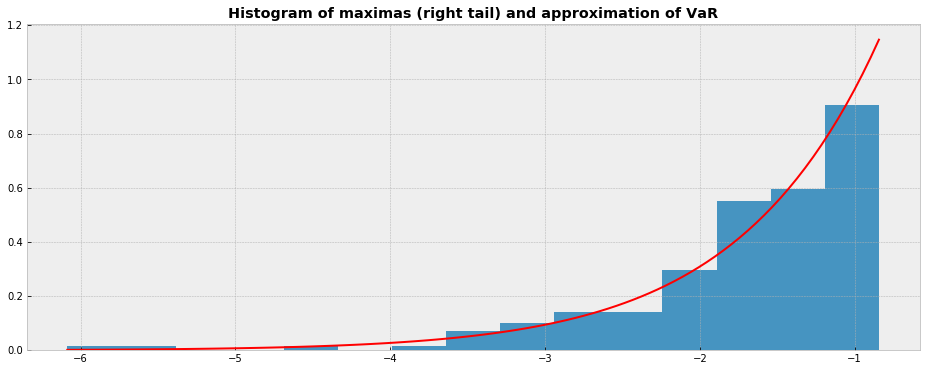

In [102]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html

c, loc, scale = scipy.stats.genpareto.fit(-ret_tail/100)

support = np.linspace(ret_tail.min(), ret_tail.max(), 100)

fig = plt.figure()
fig.set_size_inches(16,6)
plt.hist(ret_tail, bins=15, density=True, histtype="stepfilled", alpha=0.9)

plt.plot(support, scipy.stats.genpareto.pdf(-support/100, c, loc, scale)/100, "r-")
plt.title("Histogram of maximas (right tail) and approximation of VaR", weight="bold")

print(beta, loc, scale)

Text(0.5, 1.0, 'Student QQ-plot of maximal returns')

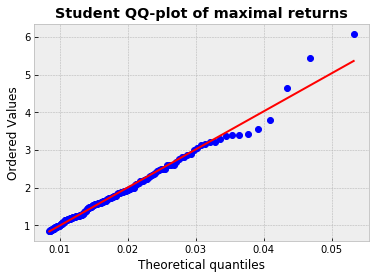

In [103]:
scipy.stats.probplot(-ret_tail, dist=scipy.stats.genpareto, sparams=(c, loc, scale), plot=plt.figure().add_subplot(111))
plt.title("Student QQ-plot of maximal returns", weight="bold")

### Мы смоделировали левый хвост распределения доходностей, осталось только правильно посчитать VaR для исходного распределения доходностей -- это остается на ДЗ, смотрите лекции ЕН

### До этого, мы никак не учитывали временную структуру доходностей -- самое время это сделать! Еще раз посмотрим на график доходностей во времени (не гистограмму)

Text(0.5, 1.0, 'Daily returns')

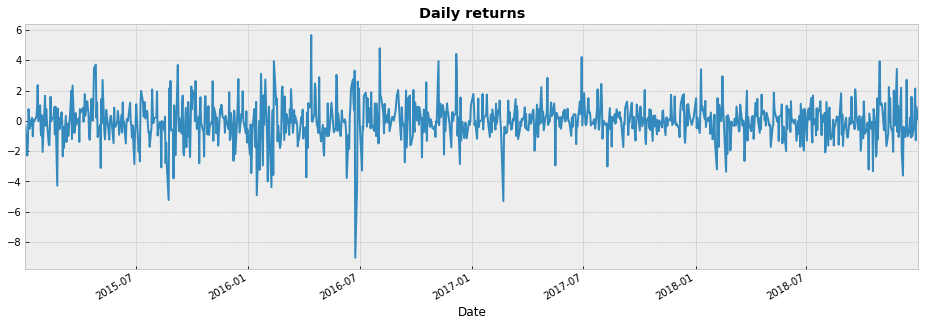

In [32]:
ret = returns['HSBC']

ret.plot(figsize=(16, 5))
plt.title("Daily returns", weight="bold")

### Для этого будем использовать модель ARMA-GARCH

### Она позволяет отдельно моделировать три компонетны нашего ряда:
 - условное среднее -- ARMA
 - условную дисперсию -- GARCH
 - распределение нормированных остатков
 
 
 Больше примеров и информации -- здесь https://arch.readthedocs.io/en/latest/univariate/introduction.html

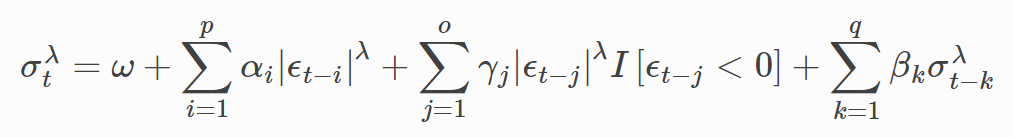

In [34]:
ret = returns['AAPL']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

In [35]:
T = 5

ret_estimation = ret[:-T]
ret_test = ret[-T:]

scaling_const = 1.0 #10 / ret_estimation.std()

dist = 'ged'
am = arch_model(scaling_const * ret_estimation,
                    mean='HARX', lags=5, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

res = am.fit(update_freq=0, disp='off')

forecasts = res.forecast(horizon=T)

cond_mean = forecasts.mean.iloc[-1]
cond_var = forecasts.variance.iloc[-1]

if dist == 'Normal':
    q = am.distribution.ppf(alpha)
elif dist == 't' or dist == 'ged':
    q = am.distribution.ppf(alpha, res.params[-1:])
elif dist == 'skewstudent':
    q = am.distribution.ppf(alpha, res.params[-2:])

return_garch_forecast = cond_mean / scaling_const
VaR_garch_forecast = (cond_mean + cond_var * q) / scaling_const

return_garch_forecast.index = ret_test.index
VaR_garch_forecast.index = ret_test.index

### Вот график предыдущих значений, на которых мы оценивали параметры модели + предсказания на 5 дней вперед

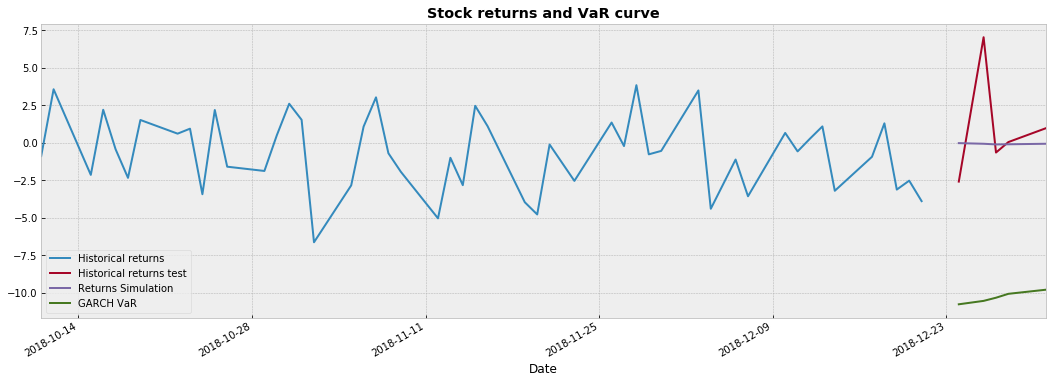

In [41]:
fig = plt.figure()
fig.set_size_inches(18, 6)
ret_estimation[-50:].plot()
ret_test.plot()

return_garch_forecast.plot()
VaR_garch_forecast.plot()

plt.title("Stock returns and VaR curve", weight="bold")

plt.legend(['Historical returns',
            'Historical returns test',
            'Returns Simulation',
           'GARCH VaR'])

Text(0.5, 1.0, 'Student QQ-plot of maximal returns')

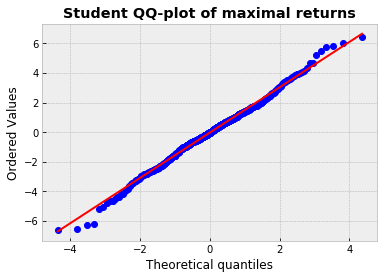

In [39]:
# , sparams=tuple(res.params[-1:])
scipy.stats.probplot(res.resid.dropna(), dist=am.distribution, sparams=(res.params[-1:],), plot=plt.figure().add_subplot(111))
plt.title("Student QQ-plot of maximal returns", weight="bold")

In [42]:
tuple(res.params[-2:])

(0.8714822484602681, 1.1547437551002853)

### Теперь, когда мы научились моделировать распределение доходностей и предсказывать Value-at-Risk, нужно двигаться дальше -- предсказывать его на регулярной основе и использовать для управления портфелем

### Но сначала нам нужно посмотреть, как мы делаем предсказания Value-at-Risk различными моделями, и выбрать наилучшую

### Для этого мы будем делать бэктестирование -- проходиться скользящим окном по нашим данным и делать предсказание на каждый следующий день

In [40]:
def calculate_var_HS(returns, alpha):
    
    return returns.quantile(alpha)


def calculate_var_gennorm(returns, alpha):
    beta, loc, scale = scipy.stats.gennorm.fit(returns)
    
    return scipy.stats.gennorm.ppf(alpha, beta, loc, scale)


def calculate_var_garch(returns, alpha):
    
    scaling_const = 1.0 #10 / ret_estimation.std()

    dist = 'ged'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=0, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = forecasts.mean.iloc[-1]
    cond_var = forecasts.variance.iloc[-1]

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + cond_var * q) / scaling_const

    return float(return_garch_forecast), float(VaR_garch_forecast)

In [112]:
ret = returns['AAPL']

returns.columns

Index(['AAPL', 'HSBC', 'TM'], dtype='object')

In [15]:
alpha = 0.1

T = len(ret)
T_start = 100
estimation_window = 500
testing_window = T - estimation_window

VaR_curve_HS = []
VaR_curve_gennorm = []
VaR_curve_garch = []
forecast_garch = []

for t in range(estimation_window+T_start, T):
    
    current_estimation_sample = ret[t-estimation_window:t]

    VaR_curve_HS.append(calculate_var_HS(current_estimation_sample, alpha))
    VaR_curve_gennorm.append(calculate_var_gennorm(current_estimation_sample, alpha))
    
    return_garch_forecast, VaR_garch_forecast = calculate_var_garch(current_estimation_sample, alpha)
    forecast_garch.append(return_garch_forecast)
    VaR_curve_garch.append(VaR_garch_forecast)
    
VaR_curve_HS = pd.Series(VaR_curve_HS, index=ret[estimation_window+T_start:].index)
VaR_curve_gennorm = pd.Series(VaR_curve_gennorm, index=ret[estimation_window+T_start:].index)
VaR_curve_garch = pd.Series(VaR_curve_garch, index=ret[estimation_window+T_start:].index)
forecast_garch = pd.Series(forecast_garch, index=ret[estimation_window+T_start:].index)

NameError: name 'ret' is not defined

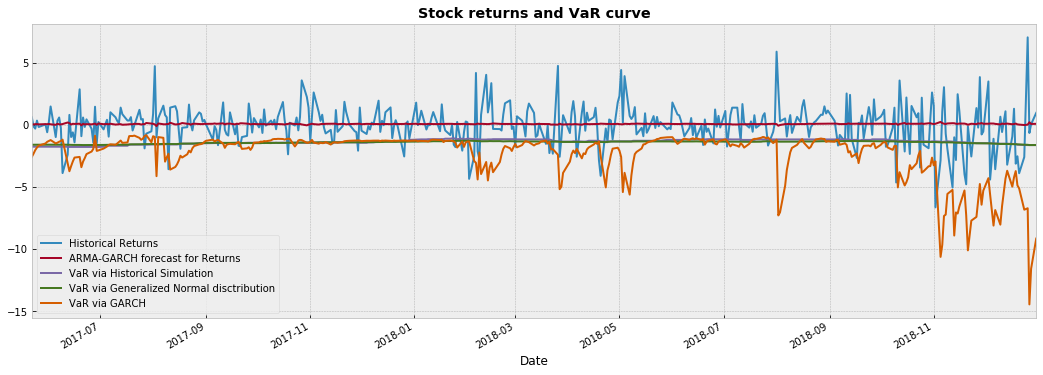

In [114]:
fig = plt.figure()
fig.set_size_inches(18,6)
ret[estimation_window+T_start:].plot()
forecast_garch.plot()
VaR_curve_HS.plot()
VaR_curve_gennorm.plot()
VaR_curve_garch.plot()

plt.title("Stock returns and VaR curve", weight="bold")

plt.legend(['Historical Returns',
            'ARMA-GARCH forecast for Returns',
            'VaR via Historical Simulation',
            'VaR via Generalized Normal disctribution',
           'VaR via GARCH'])

### Таким образом, мы для каждого способа моделирования получили кривую VaR

### Открытые вопросы -- какой способ подсчета VaR выбрать? И Как моделировать доходность портфеля из нескольких активов?

### Это узнаем на следующем занятии!